# Purpose

### Load the frozen pipeline (.pkl) and evaluate it.

### Produce plots & tables for a stakeholder-ready report.

### Optional: threshold tuning, subgroup analysis, and explainability.

## Imports

In [1]:
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from joblib import load
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve

from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve,
    classification_report, brier_score_loss
)

## Setup & load artifacts

In [3]:
OUT = Path("../outputs")
DATA = Path("../data/clean")

# pick the latest artifacts from 03
model_file   = sorted(OUT.glob("model_best.joblib"))[-1]
metrics_txt= sorted(OUT.glob("*_metrics.txt"))[-1]
clean_csv  = sorted(DATA.glob("train_clean_*.csv"))[-1]  # same split logic as 03

print("Model:", model_file.name)
print("Metrics file:", metrics_txt.name)
print("Data:", clean_csv.name)

clf = load(model_file)
df  = pd.read_csv(clean_csv)
target = "Survived"
X = df.drop(columns=[target])
y = df[target].astype("int64")

Model: model_best.joblib
Metrics file: titanic_feature_sel_20251019-214416_metrics.txt
Data: train_clean_20251019-211325.csv


## Predict & basic metrics

In [4]:
proba = clf.predict_proba(X)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("ROC-AUC :", round(roc_auc_score(y, proba), 4))
print("PR-AUC  :", round(average_precision_score(y, proba), 4))
print("Accuracy:", round(accuracy_score(y, pred), 4))
print("Precision/Recall/F1:",
      round(precision_score(y, pred), 4),
      round(recall_score(y, pred), 4),
      round(f1_score(y, pred), 4))
print("\nClassification report:\n", classification_report(y, pred, digits=4))
print("Brier score (calibration):", round(brier_score_loss(y, proba), 4))
print("Confusion matrix:\n", confusion_matrix(y, pred))

ROC-AUC : 0.9252
PR-AUC  : 0.904
Accuracy: 0.8586
Precision/Recall/F1: 0.8176 0.8129 0.8152

Classification report:
               precision    recall  f1-score   support

           0     0.8838    0.8871    0.8855       549
           1     0.8176    0.8129    0.8152       342

    accuracy                         0.8586       891
   macro avg     0.8507    0.8500    0.8504       891
weighted avg     0.8584    0.8586    0.8585       891

Brier score (calibration): 0.108
Confusion matrix:
 [[487  62]
 [ 64 278]]


## Curves (ROC & PR)

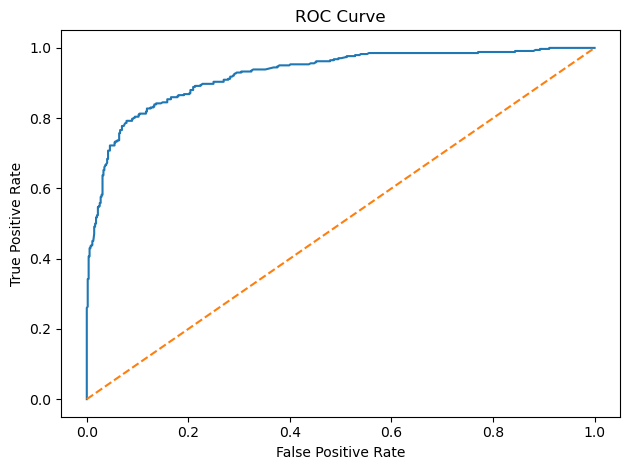

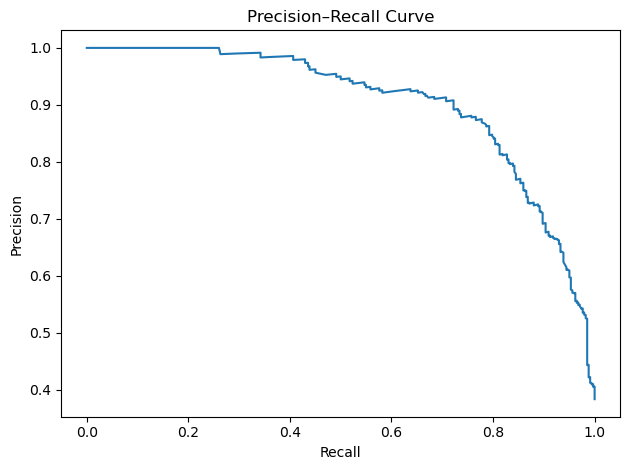

In [5]:
# ROC
fpr, tpr, _ = roc_curve(y, proba)
plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.tight_layout(); plt.show()

# Precision–Recall
prec, rec, _ = precision_recall_curve(y, proba)
plt.figure(); plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve"); plt.tight_layout(); plt.show()


## Threshold tuning

In [6]:
def pick_threshold(y_true, p, metric="f1"):
    thr = np.linspace(0.05, 0.95, 19)
    rows = []
    for t in thr:
        yhat = (p >= t).astype(int)
        rows.append({
            "thr": t,
            "precision": precision_score(y_true, yhat, zero_division=0),
            "recall":    recall_score(y_true, yhat, zero_division=0),
            "f1":        f1_score(y_true, yhat, zero_division=0),
        })
    dfm = pd.DataFrame(rows).set_index("thr")
    return dfm, dfm[metric].idxmax()

grid, best = pick_threshold(y, proba, metric="f1")
print(grid.round(3).head())
print("Best threshold by F1:", round(float(best),3))

      precision  recall     f1
thr                           
0.05      0.401   1.000  0.572
0.10      0.448   0.985  0.616
0.15      0.506   0.985  0.669
0.20      0.556   0.962  0.704
0.25      0.613   0.944  0.743
Best threshold by F1: 0.5


## Subgroup fairness / slices

In [7]:
def slice_report(df, y, proba, pred, col):
    print(f"\n=== Slice by {col} ===")
    for v, i in df.groupby(col).groups.items():
        yv, pv, hv = y.iloc[i], proba[i], pred[i]
        print(str(v), "N=", len(i),
              "AUC=", round(roc_auc_score(yv, pv), 3),
              "F1=",  round(f1_score(yv, hv), 3),
              "Acc=", round(accuracy_score(yv, hv), 3))

for c in ["Sex", "Pclass", "Embarked"]:
    if c in df.columns:
        slice_report(df, y, proba, pred, c)



=== Slice by Sex ===
female N= 314 AUC= 0.907 F1= 0.895 Acc= 0.834
male N= 577 AUC= 0.866 F1= 0.606 Acc= 0.872

=== Slice by Pclass ===
1 N= 216 AUC= 0.943 F1= 0.892 Acc= 0.856
2 N= 184 AUC= 0.95 F1= 0.912 Acc= 0.918
3 N= 491 AUC= 0.88 F1= 0.643 Acc= 0.837

=== Slice by Embarked ===
C N= 168 AUC= 0.919 F1= 0.851 Acc= 0.833
Q N= 77 AUC= 0.922 F1= 0.818 Acc= 0.844
S N= 644 AUC= 0.924 F1= 0.797 Acc= 0.866


## Feature inspection (post-selection names)

In [11]:
# names after preprocess
pp_names = clf.named_steps["preprocess"].get_feature_names_out()

# selected mask + final model coef
selector = clf.named_steps.get("select", "passthrough")
if selector == "passthrough" or not hasattr(selector, "get_support"):
    support_mask = np.ones(len(pp_names), dtype=bool)
    selected_names = np.array(pp_names)
else:
    support_mask = selector.get_support()
    selected_names = np.array(pp_names)[support_mask]

est = clf.named_steps["clf"]

# 4) vetor de importância/coefs alinhado às features selecionadas
if hasattr(est, "coef_"):  # LogisticRegression
    importance = np.abs(est.coef_).ravel()
elif hasattr(est, "feature_importances_"):  # RandomForest
    importance = est.feature_importances_.ravel()
else:
    raise AttributeError("O estimador não expõe coef_ nem feature_importances_.")

# 5) ranking
rank_df = (
    pd.DataFrame({"feature": selected_names, "importance": importance})
      .sort_values("importance", ascending=False, ignore_index=True)
)
print(f"Selecionadas: {len(selected_names)} / {len(pp_names)}")
display(rank_df.head(10))


Selecionadas: 11 / 11


,feature,importance
0,Sex_male,0.228326
1,Sex_female,0.219859
2,Fare,0.186099
3,Age,0.133509
4,Pclass,0.094917
5,FamilySize,0.050436
6,SibSp,0.028124
7,Parch,0.022881
8,Embarked_S,0.015333
9,Embarked_C,0.014436


## Permutation importance (robust, model-agnostic)

In [12]:
pi = permutation_importance(clf, X, y, scoring="roc_auc", n_repeats=10, random_state=42)
pi_df = pd.DataFrame({"feature": X.columns, "import_mean": pi.importances_mean}) \
          .sort_values("import_mean", ascending=False)
pi_df.head(15)


,feature,import_mean
3,Sex,0.240882
8,Fare,0.062797
4,Age,0.045943
1,Pclass,0.039894
5,SibSp,0.020523
10,Embarked,0.018162
6,Parch,0.012652
2,Name,0.000000
0,PassengerId,0.000000
7,Ticket,0.000000


## Calibration curve

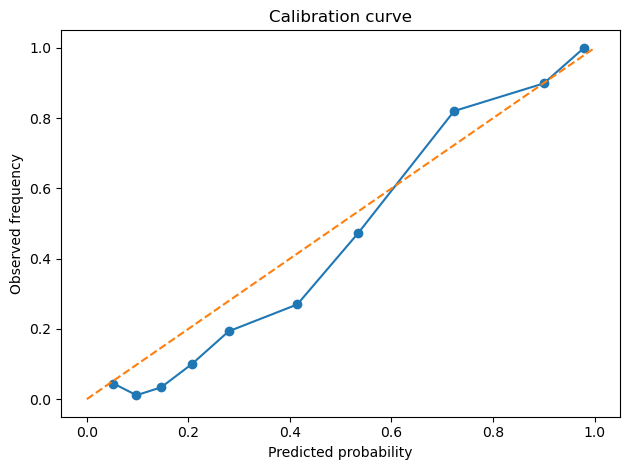

In [13]:
prob_true, prob_pred = calibration_curve(y, proba, n_bins=10, strategy="quantile")
plt.figure(); plt.plot(prob_pred, prob_true, marker="o"); plt.plot([0,1],[0,1],"--")
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title("Calibration curve"); plt.tight_layout(); plt.show()


## Robustness & stability analysis

Seed    0: AUC = 0.8657
Seed   42: AUC = 0.8785
Seed  123: AUC = 0.8759
Seed  999: AUC = 0.8713
Seed 2025: AUC = 0.8643

Mean AUC: 0.8711 ± 0.0055


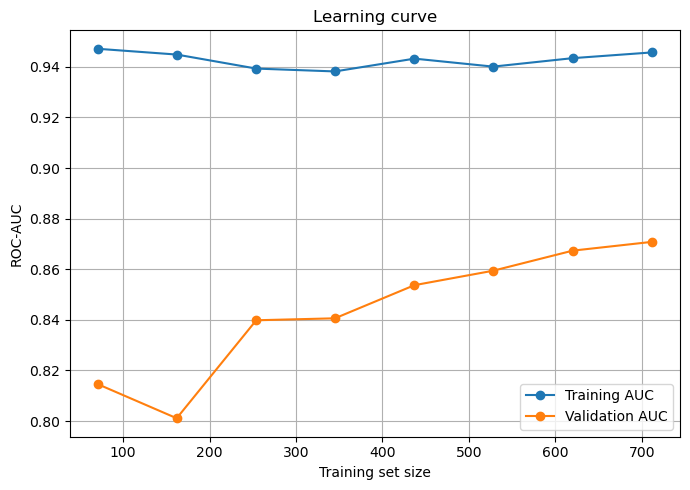

In [14]:
# K-fold with different seeds
auc_scores = []
for seed in [0, 42, 123, 999, 2025]:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    score = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc").mean()
    auc_scores.append(score)
    print(f"Seed {seed:4d}: AUC = {score:.4f}")

print("\nMean AUC:", np.mean(auc_scores).round(4), "±", np.std(auc_scores).round(4))

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    clf, X, y, cv=5, scoring="roc_auc", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 8)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, 'o-', label="Training AUC")
plt.plot(train_sizes, test_mean, 'o-', label="Validation AUC")
plt.xlabel("Training set size")
plt.ylabel("ROC-AUC")
plt.title("Learning curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluation report

In [15]:
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
report_csv = OUT / f"eval_report_{ts}.csv"

eval_df = pd.DataFrame({
    "metric": ["roc_auc","pr_auc","accuracy","brier"],
    "value": [
        roc_auc_score(y, proba),
        average_precision_score(y, proba),
        accuracy_score(y, pred),
        brier_score_loss(y, proba),
    ]
})
eval_df.to_csv(report_csv, index=False)
print("Saved:", report_csv)

Saved: ..\outputs\eval_report_20251019-215736.csv


## Model Card


Model: Random Forest or Logistic Regression (best model automatically selected).

Data: Titanic (cleaned vX, engineered vY).

Target: Survived.

Metrics: ROC-AUC, PR-AUC, Accuracy, F1, threshold.

Fairness: any subgroup gaps noted.

Calibration: Brier score / calibration curve.

Limitations & risks: small dataset, historical bias.

Reproducibility: Python / sklearn versions, random seed.